In [1]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
import copy
from gym import wrappers


In [2]:
# env = gym.make('MountainCar-v0')
env = gym.make('CartPole-v1')

action_space=[0,1]
num_states = env.observation_space.shape[0]

In [3]:
seed = 100
env.seed(seed)
torch.manual_seed(seed)

In [4]:
# Hyper - Parameters

NUMBER_OF_EPISODES = 500
hyper_parameters = {}
hyper_parameters['learning_rate'] = 0.01
hyper_parameters['max_timesteps'] = 500
hyper_parameters['epsilon'] = 0.9
hyper_parameters['epsilon_decay'] = 0.999
hyper_parameters['epsilon_min'] = 0.02
hyper_parameters['discount_factor'] = 0.995
hyper_parameters['replay_length'] = 64
hyper_parameters['batch_size'] = 32
hyper_parameters['target_update'] = 1

In [5]:

class Net(nn.Module):
    def __init__(self , input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim,64)
        self.fc2 = nn.Linear(64,output_dim)

    def forward(self, x):
        output = torch.tanh(self.fc1(x))
        output = self.fc2(output)
        return output

In [7]:

class DQN(object):
    def __init__(self):
        self.policy_network = Net(num_states,len(action_space))
        self.target_network = Net(num_states,len(action_space))
        self.target_network.load_state_dict(self.policy_network.state_dict())
        
        self.D = []
        self.D_length = hyper_parameters['replay_length']
        self.optimizer = optim.Adam(params=self.policy_network.parameters() , lr=hyper_parameters['learning_rate'])
        self.loss_func = torch.nn.MSELoss()
    def get_action(self,state):
      
        with torch.no_grad():
            state = torch.Tensor(state)
            q_values = self.policy_network(state)
            action = torch.max(q_values,0)[1]
    
        return action.item()
  
    def update_nn(self, minibatch):#state, action, next_state, reward, done):
        for state, action, next_state, reward, done in minibatch:
          state = torch.Tensor(state)
          next_state = torch.Tensor(next_state)
      
          reward = torch.Tensor([reward])
          if done:
              target_value = reward
          else:
              next_state_values = self.policy_network(next_state).detach()
              target = torch.max(next_state_values)
              target_value = reward + hyper_parameters['discount_factor'] * target

          predicted_value = self.policy_network(state)[action].view(-1)

          loss = self.loss_func(predicted_value, target_value)

          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()
    
    def train(self):
      steps_total = []
      for episode in range(number_of_episodes):
        state = env.reset()
        step = 0

        if episode % hyper_parameters["target_update"] == 0:
          self.target_network.load_state_dict(self.policy_network.state_dict())
          self.target_network.eval()
        
        batch = []
        done = False
        while not done:
            step += 1
          
          

            if random.random() > hyper_parameters['epsilon']:
              action = self.get_action(state)
            else:
              action = env.action_space.sample()
              
            next_state, reward, done, info = env.step(action)

            
            # batch.append([state, action, next_state, reward, done])
            if len(self.D) >= self.D_length:
              self.D.pop(0)
            
            self.D.append([state, action, next_state, reward, done])

            
            if step%3==0:
              if len(self.D) > hyper_parameters['batch_size']:
                minibatch = random.sample(self.D, hyper_parameters['batch_size'])
                self.update_nn(minibatch)
                if hyper_parameters['epsilon'] > hyper_parameters['epsilon_min']:
                  hyper_parameters['epsilon'] *= hyper_parameters['epsilon_decay']
            # batch = []
            state = next_state

            if done:
                metrics['total_rewards'].append(step)
                metrics['epsilon_decay'].append(hyper_parameters['epsilon'])
                print("Episode : {} \t Reward : {} \t Epsilon : {}".format(episode, step, hyper_parameters['epsilon']))
                break
            
        count = 0
        for score in metrics['total_rewards'][-60:]:
          if score > 475:
            count += 1
          
                  
        if count > 40:
          # break 
          pass

    def execute(self,num_episodes):
        env = gym.make('CartPole-v1')
        env = wrappers.Monitor(env, "./gym-results", force=True)
        metrics['rewards_evaluation'] = []

        for episodes in range(num_episodes):
            step_count = 0
            state = env.reset()
            done = False
            while not done:
                action = self.get_action(state)
                state, reward, done, _ = env.step(action)
                if done:
                    reward = 0
                print(action,step_count)
#                 env.render()
                step_count += 1
            print(step_count)
            print("---------------end-----------------")
            metrics['rewards_evaluation'].append(step_count)
        print("Average reward : {}".format(sum(metrics['rewards_evaluation'])/len(metrics['rewards_evaluation'])))

In [8]:

# DQN
%matplotlib inline
# env = gym.make('CartPole-v1')


number_of_episodes = 10000
metrics = {}
metrics['timesteps'], metrics['penalties'], metrics['rewards'], metrics['total_rewards'], metrics['epsilon_decay'] = [], [], [], [], []

CP = DQN()
CP.train()



plt.plot(metrics['total_rewards'])
plt.figtext(0.5, 0.01, "Total Rewards per episode", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()
# plt.savefig('total_rewards.png')
# plt.plot(metrics['penalties'])
# plt.show()
# plt.plot(metrics['timesteps'])
# plt.show()
plt.plot(metrics['epsilon_decay'])
plt.figtext(0.5, 0.01, "Epsilon Decay", wrap=True, horizontalalignment='center', fontsize=12)
# plt.savefig('eps_decay.png')

plt.show()
# k_det.execute("deterministic")
metrics_q_det = copy.deepcopy(metrics)
PATH_1 = './CP_DQN.pth'
torch.save(CP.policy_network.state_dict(), PATH_1)

Episode : 0 	 Reward : 11 	 Epsilon : 0.9
Episode : 1 	 Reward : 16 	 Epsilon : 0.9
Episode : 2 	 Reward : 34 	 Epsilon : 0.8910403921887733
Episode : 3 	 Reward : 26 	 Epsilon : 0.8839369683463054
Episode : 4 	 Reward : 37 	 Epsilon : 0.8733878705367771
Episode : 5 	 Reward : 11 	 Epsilon : 0.8707703262153905
Episode : 6 	 Reward : 18 	 Epsilon : 0.8655587484106411
Episode : 7 	 Reward : 23 	 Epsilon : 0.8595179836412034
Episode : 8 	 Reward : 21 	 Epsilon : 0.8535193775803068
Episode : 9 	 Reward : 60 	 Epsilon : 0.836610189820452
Episode : 10 	 Reward : 60 	 Epsilon : 0.8200359922649304
Episode : 11 	 Reward : 30 	 Epsilon : 0.8118724357296152
Episode : 12 	 Reward : 30 	 Epsilon : 0.8037901483775233
Episode : 13 	 Reward : 22 	 Epsilon : 0.7981804688274572
Episode : 14 	 Reward : 25 	 Epsilon : 0.7918173294876865
Episode : 15 	 Reward : 30 	 Epsilon : 0.7839346931206392
Episode : 16 	 Reward : 18 	 Epsilon : 0.7792428283153726
Episode : 17 	 Reward : 28 	 Epsilon : 0.77225763024404

KeyboardInterrupt: 

Average reward : 500.0


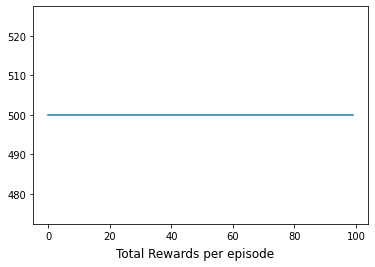

In [ ]:
num_episodes = 10000
env = gym.make('CartPole-v1')
# env = wrappers.Monitor(env, "./gym-results", force=True)
metrics['rewards_evaluation'] = []

for episodes in range(num_episodes):
    step_count = 0
    state = env.reset()
    done = False
    while not done:
        action = CP.get_action(state)
        state, reward, done, _ = env.step(action)
        if done:
            reward = 0
        # print(action,step_count)
#                 env.render()
        step_count += 1
    # print(step_count)
    # print("---------------end-----------------")
    metrics['rewards_evaluation'].append(step_count)
print("Average reward : {}".format(sum(metrics['rewards_evaluation'])/len(metrics['rewards_evaluation'])))
plt.plot(metrics['rewards_evaluation'])
plt.figtext(0.5, 0.01, "Total Rewards per episode", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

In [ ]:
import torch.nn.functional as F
class Net_DD(nn.Module):
    def __init__(self , input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim,24)
        self.fc2 = nn.Linear(24,output_dim)

    def forward(self, x):
        output = F.relu(self.fc1(x))
        output = self.fc2(output)
        return output

In [ ]:

class DDQN(object):
    def __init__(self):
        self.policy_network = Net(num_states,len(action_space))
        self.target_network = Net(num_states,len(action_space))
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.target_network.eval()
        self.D = []
        self.D_length = hyper_parameters['replay_length']
        self.optimizer = optim.Adam(params=self.policy_network.parameters() , lr=hyper_parameters['learning_rate'])
        self.loss_func = torch.nn.MSELoss()
    def get_action(self,state):
      
        with torch.no_grad():
            state = torch.Tensor(state)
            q_values = self.policy_network(state)
            action = torch.max(q_values,0)[1]
    
        return action.item()
  
    def update_nn(self, minibatch):#state, action, next_state, reward, done):
        for state, action, next_state, reward, done in minibatch:
          state = torch.Tensor(state)
          next_state = torch.Tensor(next_state)
      
          reward = torch.Tensor([reward])
          next_state_values = self.policy_network(next_state).detach()
          targetp = torch.max(next_state_values)
          if done:
              target_value = reward
          else:
              target = self.target_network(state)[action].view(-1)

              

              target_value = reward + hyper_parameters['discount_factor'] * targetp

          predicted_value = self.policy_network(state)[action].view(-1)

          loss = self.loss_func(predicted_value, target_value)

          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()
    
    def train(self):
      steps_total = []
      for episode in range(number_of_episodes):
        state = env.reset()
        step = 0

        if episode % hyper_parameters["target_update"] == 0:
          TAU = 0.5
          target_params = self.target_network.named_parameters()
          upd_params = dict(target_params)
          for model_name, model_param in self.policy_network.named_parameters():
              if model_name in target_params:
                  # Update parameter
                  upd_params[model_name].data.copy_((TAU)*model_param.data + (1-TAU)*target_params[model_param].data)
          
          self.target_network.load_state_dict(upd_params)
          self.target_network.eval()
        
        batch = []
        done = False
        while not done:
            step += 1
          
          

            if random.random() > hyper_parameters['epsilon']:
              action = self.get_action(state)
            else:
              action = env.action_space.sample()
              
            next_state, reward, done, info = env.step(action)

            
            # batch.append([state, action, next_state, reward, done])
            if len(self.D) >= self.D_length:
              self.D.pop(0)
            
            self.D.append([state, action, next_state, reward, done])

            
            if step%10==0:
              if len(self.D) > hyper_parameters['batch_size']:
                minibatch = random.sample(self.D, hyper_parameters['batch_size'])
                self.update_nn(minibatch)
                if hyper_parameters['epsilon'] > hyper_parameters['epsilon_min']:
                  hyper_parameters['epsilon'] *= hyper_parameters['epsilon_decay']
            # batch = []
            state = next_state

            if done:
                metrics['total_rewards'].append(step)
                metrics['epsilon_decay'].append(hyper_parameters['epsilon'])
                print("Episode : {} \t Reward : {} \t Epsilon : {}", episode, step, hyper_parameters['epsilon'])
                break
            
        count = 0
        for score in metrics['total_rewards'][-20:]:
          if score > 475:
            count += 1
                  
        if count > 10:
          break

    def execute(self,num_episodes):
        # env = gym.make('CartPole-v1')
        env = wrappers.Monitor(env, "./gym-results", force=True)
        metrics['rewards_evaluation'] = []

        for episodes in range(num_episodes):
            step_count = 0
            state = env.reset()
            done = False
            while not done:
                action = self.get_action(state)
                state, reward, done, _ = env.step(action)
                if done:
                    reward = 0
                print(action,step_count)
#                 env.render()
                step_count += 1
            print(step_count)
            print("---------------end-----------------")
            metrics['rewards_evaluation'].append(step_count)
        print("Average reward : {}".format(sum(metrics['rewards_evaluation'])/len(metrics['rewards_evaluation'])))

Episode : {} 	 Reward : {} 	 Epsilon : {} 0 13 0.9
Episode : {} 	 Reward : {} 	 Epsilon : {} 1 15 0.9
Episode : {} 	 Reward : {} 	 Epsilon : {} 2 34 0.8732691
Episode : {} 	 Reward : {} 	 Epsilon : {} 3 44 0.8388588131162911
Episode : {} 	 Reward : {} 	 Epsilon : {} 4 10 0.8304702249851281
Episode : {} 	 Reward : {} 	 Epsilon : {} 5 44 0.7977463845445164
Episode : {} 	 Reward : {} 	 Epsilon : {} 6 11 0.7897689206990712
Episode : {} 	 Reward : {} 	 Epsilon : {} 7 14 0.7818712314920805
Episode : {} 	 Reward : {} 	 Epsilon : {} 8 24 0.7663119939853881
Episode : {} 	 Reward : {} 	 Epsilon : {} 9 36 0.7435517614520281
Episode : {} 	 Reward : {} 	 Epsilon : {} 10 18 0.7361162438375077
Episode : {} 	 Reward : {} 	 Epsilon : {} 11 12 0.7287550813991327
Episode : {} 	 Reward : {} 	 Epsilon : {} 12 18 0.7214675305851413
Episode : {} 	 Reward : {} 	 Epsilon : {} 13 18 0.7142528552792899
Episode : {} 	 Reward : {} 	 Epsilon : {} 14 40 0.6861084429123933
Episode : {} 	 Reward : {} 	 Epsilon : {} 15

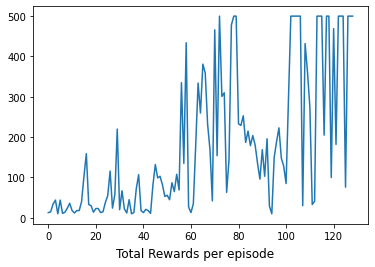

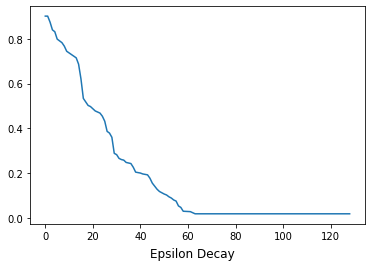

In [ ]:
env = gym.make('CartPole-v1')

action_space=[0,1]
num_states = env.observation_space.shape[0]
seed = 30
env.seed(seed)
torch.manual_seed(seed)

# Hyper - Parameters

NUMBER_OF_EPISODES = 500
hyper_parameters = {}
hyper_parameters['learning_rate'] = 0.01
hyper_parameters['max_timesteps'] = 500
hyper_parameters['epsilon'] = 0.9
hyper_parameters['epsilon_decay'] = 0.99
hyper_parameters['epsilon_min'] = 0.02
hyper_parameters['discount_factor'] = 0.995
hyper_parameters['replay_length'] = 64
hyper_parameters['batch_size'] = 32
hyper_parameters['target_update'] = 10
# DQN
%matplotlib inline
# env = gym.make('CartPole-v1')


number_of_episodes = 500
metrics = {}
metrics['timesteps'], metrics['penalties'], metrics['rewards'], metrics['total_rewards'], metrics['epsilon_decay'] = [], [], [], [], []

CP_Double = DDQN()
CP_Double.train()



plt.plot(metrics['total_rewards'])
plt.figtext(0.5, 0.01, "Total Rewards per episode", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()
plt.savefig('total_rewards.png')
# plt.plot(metrics['penalties'])
# plt.show()
# plt.plot(metrics['timesteps'])
# plt.show()
plt.plot(metrics['epsilon_decay'])
plt.figtext(0.5, 0.01, "Epsilon Decay", wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig('eps_decay.png')

plt.show()
# k_det.execute("deterministic")
metrics_DDQN = copy.deepcopy(metrics)

Average reward : 500.0


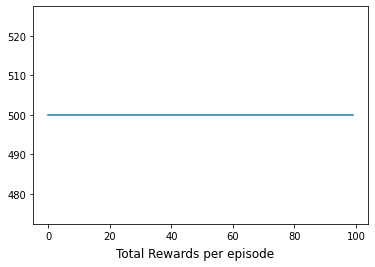

In [ ]:
num_episodes = 100
env = gym.make('CartPole-v1')
# env = wrappers.Monitor(env, "./gym-results", force=True)
metrics['rewards_evaluation'] = []

for episodes in range(num_episodes):
    step_count = 0
    state = env.reset()
    done = False
    while not done:
        action = CP_Double.get_action(state)
        state, reward, done, _ = env.step(action)
        if done:
            reward = 0
        # print(action,step_count)
#                 env.render()
        step_count += 1
    # print(step_count)
    # print("---------------end-----------------")
    metrics['rewards_evaluation'].append(step_count)
print("Average reward : {}".format(sum(metrics['rewards_evaluation'])/len(metrics['rewards_evaluation'])))
plt.plot(metrics['rewards_evaluation'])
plt.figtext(0.5, 0.01, "Total Rewards per episode", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

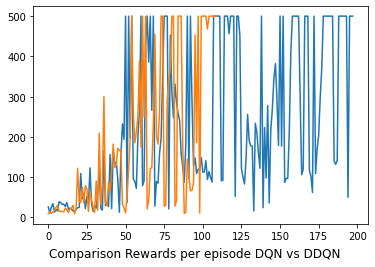

In [ ]:
plt.plot(metrics_q_det['total_rewards'])
plt.plot(metrics_DDQN['total_rewards'])


plt.figtext(0.5, 0.01, "Comparison Rewards per episode DQN vs DDQN", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()